<a href="https://colab.research.google.com/github/JehadOumer/IMDB-Reviews-Classification/blob/main/Dataset_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re



In [ ]:
(training_data, validation_data, testing_data), ds_info  = tfds.load(
    name="imdb_reviews", split=('train[:60%]', 'train[60%:]', 'test'), as_supervised=True, with_info=True)
##The label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.



In [ ]:
training_data = tfds.as_dataframe(training_data, ds_info)
validation_data= tfds.as_dataframe(validation_data, ds_info)
testing_data=tfds.as_dataframe(testing_data, ds_info)
all_data = pd.concat([training_data, testing_data, validation_data])


In [ ]:
print("Dataset length: ", len(all_data["label"]), "points")
all_data.head(5)

Dataset length:  50000 points


,label,text
0,0,"b""This was an absolutely terrible movie. Don't..."
1,0,b'I have been known to fall asleep during film...
2,0,b'Mann photographs the Alberta Rocky Mountains...
3,1,b'This is the kind of film for a snowy Sunday ...
4,1,"b'As others have mentioned, all the women that..."


In [ ]:
negative_reviews=all_data[all_data['label']==0]
positive_reviews=all_data[all_data['label']==1]
all_reviews=all_data['text']

In [ ]:
all_reviews.head(8)

0    b"This was an absolutely terrible movie. Don't...
1    b'I have been known to fall asleep during film...
2    b'Mann photographs the Alberta Rocky Mountains...
3    b'This is the kind of film for a snowy Sunday ...
4    b'As others have mentioned, all the women that...
5    b"This is a film which should be seen by anybo...
6    b'Okay, you have:<br /><br />Penelope Keith as...
7    b'The film is based on a genuine 1950s novel.<...
Name: text, dtype: object

The number of positive reviews:  25000
The number of negative reviews:  25000


Text(0.5, 1.0, 'Class Distribution')

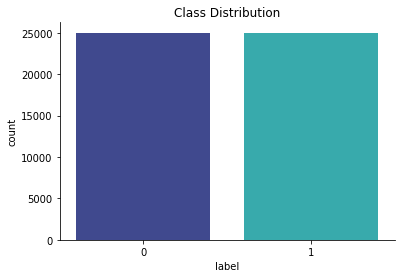

In [ ]:
## Data distribution in terms of labels
print("The number of positive reviews: ", len(positive_reviews))
print("The number of negative reviews: ", len(negative_reviews))
sns.countplot(x='label', data = all_data, palette = 'mako',
              saturation = 1)
sns.despine()
plt.title('Class Distribution')

In [ ]:
def preprocess(reviews):
  tokens = ''
    for review in reviews:
    temp = str(tweet).lower().strip()
    temp = temp.replace('\n', ' ')
    temp = temp.replace('<br />', ' ')
    temp =temp.replace('[^a-zA-Z0-9_]', ' ')
    temp = ' '.join(temp.split())
    tokens += temp + ' '
  return tokens

1309.67016
0.00036


In [ ]:
for review in all_reviews.head(8):
  str_review=str(review)
  print(' '.join(str_review.split()))

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was